===== BASELINE SVM PERFORMANCE =====
Accuracy: 0.8158

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6803
           1       0.73      0.41      0.52      2242

    accuracy                           0.82      9045
   macro avg       0.78      0.68      0.70      9045
weighted avg       0.80      0.82      0.80      9045



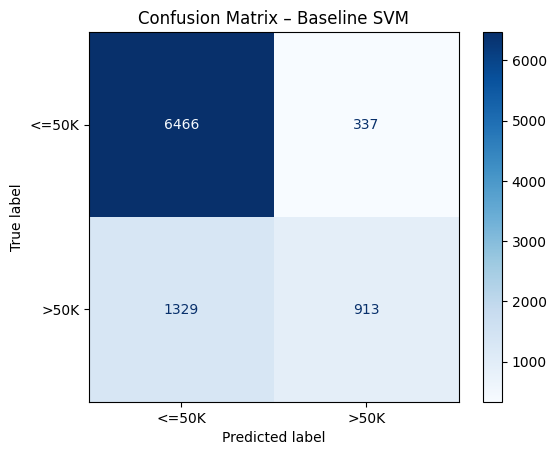


===== BEST PARAMETERS =====
{'C': 1}
Best Cross-Validation Accuracy: 0.8215

===== TUNED SVM PERFORMANCE =====
Accuracy: 0.8158

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6803
           1       0.73      0.41      0.52      2242

    accuracy                           0.82      9045
   macro avg       0.78      0.68      0.70      9045
weighted avg       0.80      0.82      0.80      9045



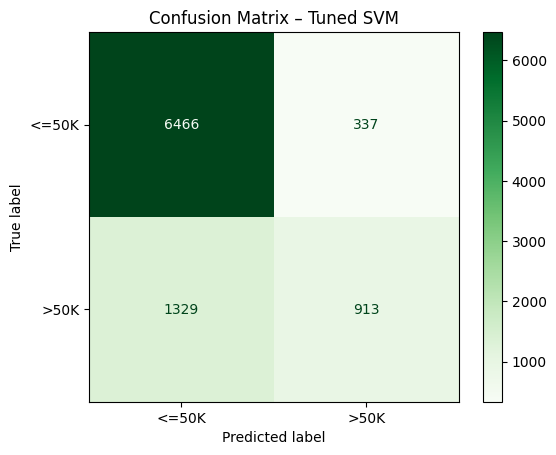

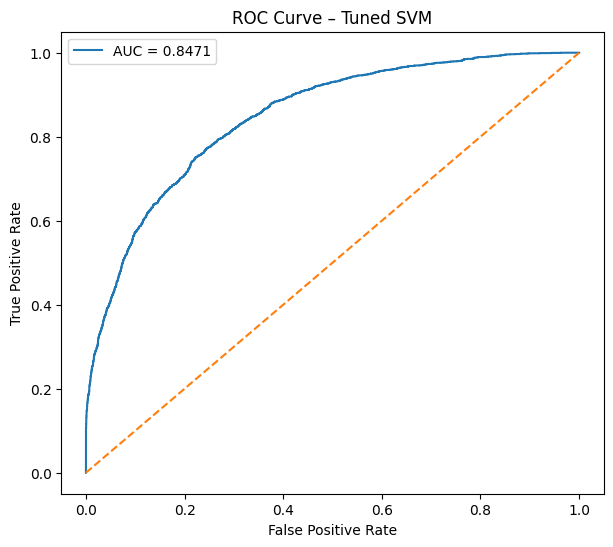

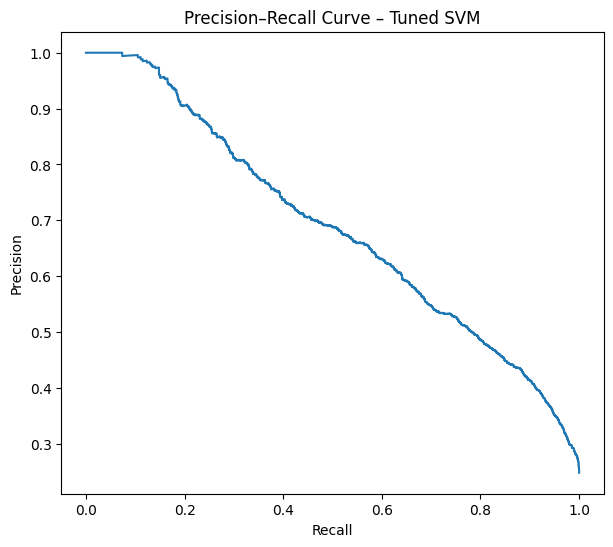

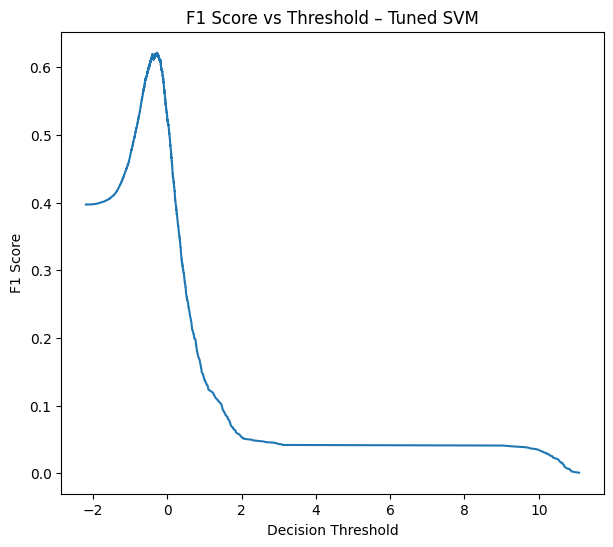

In [4]:
# =========================================
# Experiment 5: Support Vector Machine (SVM)
# FAST & FINAL VERSION
# Dataset: Adult Income
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve, f1_score
)

# -----------------------------------------
# 1. Load Dataset
# -----------------------------------------
df = pd.read_csv("adult.csv")

# Handle missing values
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# -----------------------------------------
# 2. Encode Categorical Variables
# -----------------------------------------
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# -----------------------------------------
# 3. Features and Target
# -----------------------------------------
X = df.drop("income", axis=1)
y = df["income"]

# -----------------------------------------
# 4. Train-Test Split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------------
# 5. Feature Scaling (MANDATORY for SVM)
# -----------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================================
# PART 1: BASELINE LINEAR SVM
# =========================================
svm_baseline = LinearSVC(C=1, max_iter=5000)
svm_baseline.fit(X_train_scaled, y_train)

y_pred_base = svm_baseline.predict(X_test_scaled)

print("===== BASELINE SVM PERFORMANCE =====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_base))

# Confusion Matrix (Baseline)
cm_base = confusion_matrix(y_test, y_pred_base)
disp_base = ConfusionMatrixDisplay(
    confusion_matrix=cm_base,
    display_labels=["<=50K", ">50K"]
)

disp_base.plot(cmap="Blues")
plt.title("Confusion Matrix – Baseline SVM")
plt.show()

# =========================================
# PART 2: SVM WITH HYPERPARAMETER TUNING
# =========================================
param_grid = {
    'C': [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(
    LinearSVC(max_iter=5000),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("\n===== BEST PARAMETERS =====")
print(grid.best_params_)
print(f"Best Cross-Validation Accuracy: {grid.best_score_:.4f}")

best_svm = grid.best_estimator_

y_pred = best_svm.predict(X_test_scaled)

print("\n===== TUNED SVM PERFORMANCE =====")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix (Tuned)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["<=50K", ">50K"]
)

disp.plot(cmap="Greens")
plt.title("Confusion Matrix – Tuned SVM")
plt.show()

# =========================================
# PART 3: ROC, PR, F1 vs Threshold (Tuned)
# =========================================

# Get decision scores
y_scores = best_svm.decision_function(X_test_scaled)

# ---------- ROC Curve ----------
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Tuned SVM")
plt.legend()
plt.show()

# ---------- Precision–Recall Curve ----------
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Tuned SVM")
plt.show()

# ---------- F1 Score vs Threshold ----------
f1_scores = []
for thresh in pr_thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

plt.figure(figsize=(7, 6))
plt.plot(pr_thresholds, f1_scores)
plt.xlabel("Decision Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold – Tuned SVM")
plt.show()
